## Klimadynamics tasks 4
### 3. December
Egor Gordeev

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
from scipy.linalg import det, inv, eig
from numpy.random import normal as norm
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from scipy.stats import pearsonr

### Part 1

Read HadSLP2 (Allan & Ansell, 2006) gridded global sea level pressure (SLP)
anomalies from 1850 to 2004. Again extract the December months (alternatively
you may average over the December to February (DJF) season). Plot the longterm
mean SLP field for December (or DJF).


In [2]:
fname="/home/igor/UNI/KLIMDYN/Hometask/ex2/HadSLP2_slp-mnmean-real.nc"

In [3]:
with xr.open_dataset(fname) as ds:
    print(ds.keys())

KeysView(<xarray.Dataset>
Dimensions:    (lat: 37, lon: 72, nbnds: 2, time: 2033)
Coordinates:
  * lat        (lat) float32 90.0 85.0 80.0 75.0 ... -75.0 -80.0 -85.0 -90.0
  * lon        (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2019-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    slp        (time, lat, lon) float32 ...
Attributes:
    title:        HadSLP2 Real-Time
    history:      Created 02/2006 by CAS
    comments:     adSLP2 was created using marine observations taken from ICO...
    Conventions:  CF-1.0
    platform:     Model
    source:       Hadley Center
    institution:  Hadley Center
    References:   https://hadobs.metoffice.com/gmslp/hadslp2/\nhttps://psl.no...)


In [4]:
ds_dec=ds.sel( time=ds['time.month']==1)

In [5]:
ds_dec.lat.values

array([ 90.,  85.,  80.,  75.,  70.,  65.,  60.,  55.,  50.,  45.,  40.,
        35.,  30.,  25.,  20.,  15.,  10.,   5.,   0.,  -5., -10., -15.,
       -20., -25., -30., -35., -40., -45., -50., -55., -60., -65., -70.,
       -75., -80., -85., -90.], dtype=float32)

Text(0.5, 1.0, 'SLP mean December (1850-2019)')

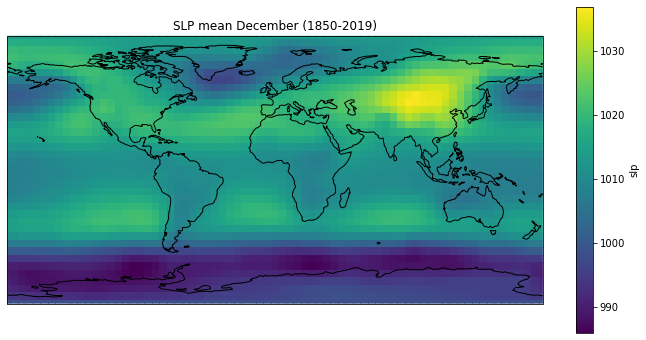

In [6]:
fig=plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_dec.slp.mean(axis=0).plot()
ax.coastlines()
plt.title('SLP mean December (1850-2019)')


In [7]:
# 170 time steps (years), 37 Y steps (latitude), 72 X steps (longitude, zones)
ds_dec.slp.shape

(170, 37, 72)

In [8]:
# find matrix H by averaging over longitudes
H=ds_dec.slp.mean(axis=2)

### Part 1
Calculate the empirical orthogonal functions (EOF) and the principal components
PC) for a selected region, e.g. the North-Atlantic/European sector (20 ◦ N - 70 ◦ N ;
80 ◦ W - 20 ◦ E or the Tropics between 20 ◦ S and 20 ◦ N.
- Data are now in a 3 dimensional array. Reorganize data into a 2 dimensional
matrix (i.e. reorganize spatial fields of dimensions nlon × nlat into vector of
length nlonn ̇ lat)
- Calculate weighted covariance matrix. The weights should account for the
area that is represented by the grid point, which is proportianal to the cosine
of the geographic latitude.
- Now you can proceed as in Exercise III. To perform the eigen decomposition
you may program it in the efficient way by diagonalizing D T D instead of
DD T .
- To prepare for plotting the eigenvectors (EOF) you have to reshape the vector
onto the original 2-dimensional spatial region.
- Plot EOF and PC related to the two larges eigenvalues. Look also at
eigenvalue spectrum and explained variances of the first 10 eigenmodes.

In [9]:
def getlons(loninput,lonxr):
    #correction considering that there are 
    assert len(loninput)==2
    corrected_flag=False
    corrected_list=[]
    for lon in loninput: 
        value=int(lon[:-1])
        hemisphere=lon[-1]
        if hemisphere=='E':
            pass
        elif hemisphere=='W':
            value=360-value
            corrected_flag=True
        corrected_list.append(value)
    
    lon1,lon2=corrected_list
    if corrected_flag:
        lonsE=lonxr[ (lon2>=lonxr) ]
        lonsW=lonxr[(lon1<=lonxr) ]
        lonbox=np.concatenate((lonsW,lonsE))
    else:
        if lon1>lon2:
            pass
        else:
            lon1,lon2=lon2,lon1 
        lonbox=lonxr[(lon2<=lonxr) & (lonxr<=lon1)]
    
    return lonbox
    

In [10]:
def getlats(latinput,latxr):
    assert len(latinput)==2
    
    lat1=int(latinput[0][:-1])
    hemisphere=latinput[0][-1]
    if hemisphere=='N':
        pass
    elif hemisphere=='S':
        lat1=-lat1
        
    lat2=int(latinput[1][:-1])
    hemisphere=latinput[1][-1]
    
    if hemisphere=='N':
        pass
    elif hemisphere=='S':
        lat2=-lat2
    
    if lat1>lat2:
        pass
    else:
        lat1,lat2=lat2,lat1 
        
    latbox=latxr[(lat2<=latxr) & (latxr<=lat1)]
    
    return latbox

In [11]:
#############################################
# 1. choose the region - 3d array nx,ny,ntime
#############################################
def select_area(latinput,loninput,DataArray):
    # DataArray - xarray DataArray object
    # latinput, loninput should be in following format
    # e.g. latinput=['30S','20N'], loninput=['80W','20E']
    latxr=DataArray.lat.values
    latlist=getlats(latinput,latxr)
       
    lonxr=DataArray.lon.values
    lonlist=getlons(loninput,lonxr)
    
    area=DataArray.sel(lon=lonlist,lat=latlist)

    return area

In [65]:
##############################################
# 2. produce 2d array (ntime,nx*ny) - matrix H
##############################################
def flatten_data(area):
    # area - xarray.core.dataarray.DataArray 
    ntime=area.time.shape[0]
    flat_list=[]
    for time in range(ntime):
        flat_vals=area[time].values.flatten()
        flat_list.append(flat_vals)
    flat_arr=np.vstack(flat_list)
    
    return flat_arr

In [189]:
#################################
# 3. get anomaly matrix D from H
################################

def get_deviation_vect(cell_vect,ntime_steps):
    cell_mean=sum(cell_vect)/ntime_steps
    # deviation_vect - deviations from mean
    deviation_vect=cell_vect-cell_mean
    deviation_vect
    
    return deviation_vect

def get_D(H):
    ntime_steps=H.shape[0]
    nxny=H.shape[1]
    dev_list=[]
    for cell in range(nxny):
        # vector with 170 time entries for each of nx*ny area cells
        cell_vect=H[:,cell]
        dev_list.append(get_deviation_vect(cell_vect,ntime_steps))

    D=np.array(dev_list)
    
    return D,ntime_steps

################################
# 4. get filtered anomaly matrix
#    n principle components
################################
def get_eig(covmat):
    # eig returns The normalized left eigenvector corresponding to the eigenvalue
    #``w[i]`` is the column vl[:,i]
    l, E = eig(covmat)  # eigen_val, eigen_vec
    idx = l.argsort()[::-1] 
    # E - eigenvector rows, E.T - eigenvector columns
    E_sort = np.array([E[:, i] for i in idx]).T  # reorder as eig doesn't necessarily return ordered values
    # l_sort = l[idx]
    
    return E_sort

def filter(D,nprinciple):
    # compute coavariance matrix from  D
    covmat = 1/m * np.matmul(D,D.T)
    # calculate eigenvectors matrix E (sorted)
    E=get_eig(covmat)
    # assume proper array shape
    assert E[:,:nprinciple].shape[0]==D.shape[0]
    filter_matrix=np.matmul(E[:,:nprinciple],E[:,:nprinciple].T)
    
    return np.matmul(filter_matrix,D)

#################################
# 5. get filtered,weighted anomaly matrix
#    n principle components
################################
def get_weights(latlist,nlons):
    coslist=np.cos(np.deg2rad(latlist))
    rootlist=np.sqrt(coslist)
    #coslist[0]=coslist[-1]=0
    diagarr=[nlons*[i] for i in rootlist]
    diagarr=np.concatenate(diagarr)
    W=np.diag(np.sqrt(diagarr))

    return W

def weighted_filter(H,W,nprinciple):
    # compute D 
    D,m=get_D(H)
    # comopute weighted D
    Dw=np.matmul(W,D)
    # compute coavariance matrix from weighted D
    covmat = 1/m * np.matmul(Dw,Dw.T)
    # calculate eigenvectors matrix E (sorted)
    E=get_eig(covmat)
    # get filter matrix by multiplying n principle components of E
    assert E[:,:nprinciple].shape[0]==D.shape[0]
    filter_matrix=np.matmul(E[:,:nprinciple],E[:,:nprinciple].T)
    # apply filter matrix
    Dfil=np.matmul(filter_matrix,D)
    
    return Dfil

In [247]:
#############################################
# 1. choose the region - 3d array nx,ny,ntime
#############################################
latinput=['70N','20N']
loninput=['80W','20E']
DataArray=ds_dec.slp
area=select_area(latinput,loninput,DataArray)

##############################################
# 2. produce 2d array (ntime,nx*ny) - matrix H
##############################################
H=flatten_data(area) 

#################################
# 3. get anomaly matrix D from H
################################
D,m=get_D(H)

#################################
# 4. get filtered anomaly matrix
#    n principle components
################################
nprinciple=3
Dfil=filter(D,nprinciple)

#################################
# 5. get filtered,weighted anomaly matrix
#    n principle components
################################
latlist=area.lat.values
nlons=area.lon.values.shape[0]
W=get_weights(latlist,nlons)
Dfil_weight=weighted_filter(H,W,nprinciple)

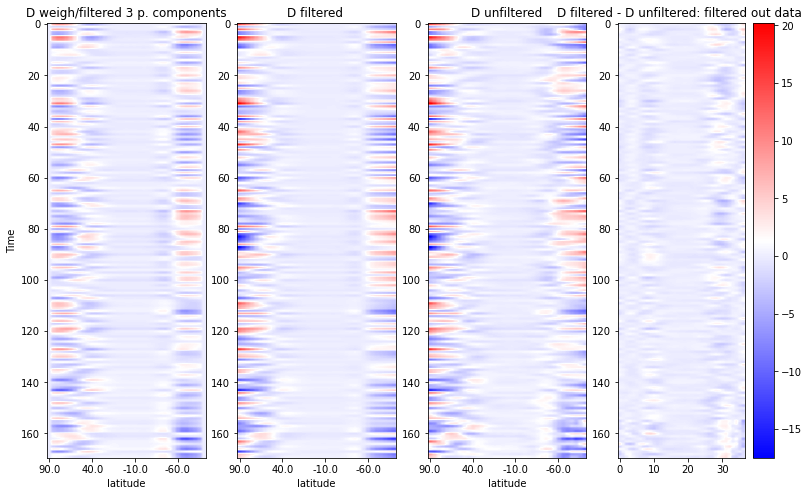

In [199]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4,figsize=(15,8))
ax1.imshow(Dfil_weight.T,aspect='auto',vmin=Dfil.min(), vmax=Dfil.max(),cmap='bwr')
ax1.set_title('D weigh/filtered {} p. components'.format(nprinciple))
ax1.set_ylabel('Time')
ax3.imshow(D.T,aspect='auto',vmin=Dfil.min(), vmax=Dfil.max(),cmap='bwr')
ax3.set_title('D unfiltered')
ax2.imshow(Dfil.T,aspect='auto',vmin=Dfil.min(), vmax=Dfil.max(),cmap='bwr')
ax2.set_title('D filtered ')
im=ax4.imshow((Dfil-D).T,aspect='auto',vmin=Dfil.min(), vmax=Dfil.max(),cmap='bwr')
ax4.set_title('D filtered - D unfiltered: filtered out data ')
for ax in [ax1,ax2,ax3]:
    ax.set_xticks(range(37)[::10])
    ax.set_xticklabels(latlist[::10])
    ax.set_xlabel('latitude')
   

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes()
fig.colorbar(im, cax=cbar_ax)
plt.show()

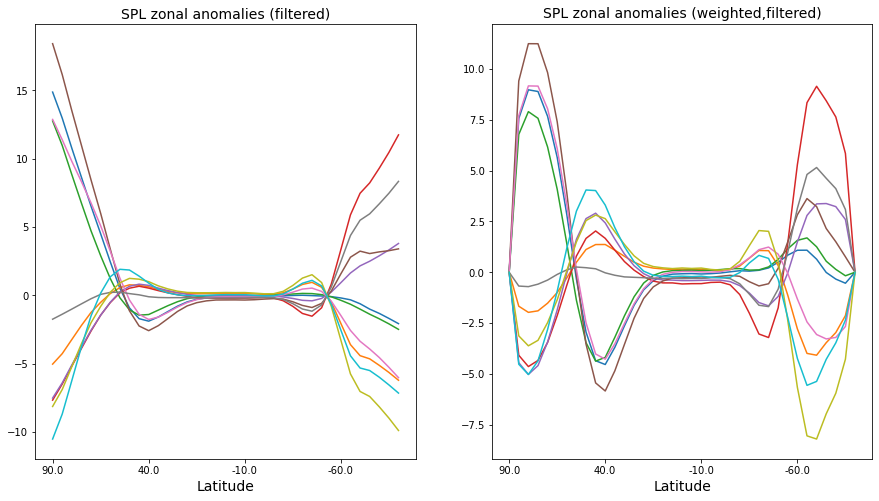

In [198]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,8))
ax1.plot(Dfil[:,:10])
ax1.set_title('SPL zonal anomalies (filtered)',fontsize=14)
ax1.set_xticks(range(37)[::10])
ax1.set_xticklabels(latlist[::10])
ax1.set_xlabel('Latitude',fontsize=14)
ax2.plot(Dfil_weight[:,:10])
ax2.set_title('SPL zonal anomalies (weighted,filtered)',fontsize=14)
ax2.set_xlabel('Latitude',fontsize=14)
ax2.set_xticks(range(37)[::10])
ax2.set_xticklabels(latlist[::10])
plt.show()
